## Feature Analysis
### Christopher V. Cosgriff, MPH
#### Harvard Chan School, NYU School of Medicine
<hr />

In this notebook we will carry out feature analysis on the ridge regression and gradient boosting models in an effort to improve our understanding of their performance differences across the control and high-risk training cohorts in forecasting mortality in high-risk patients.

## 0 - Environement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from modelanalysis import gen_logodds_plot, tableau20

from xgboost import XGBClassifier, plot_importance

## 1 - Models, Data, and Helper Functions

We first load up the fully trained models.

In [2]:
ridge_classifier = pickle.load(open('./models/ridge_full-cohort', 'rb'))
ridge_classifier_HR = pickle.load(open('./models/ridge_HR-cohort', 'rb'))
xgb_classifier = pickle.load(open('./models/xgb_full-cohort', 'rb'))
xgb_classifier_HR = pickle.load(open('./models/xgb_HR-cohort', 'rb'))

We then load up the testing data and generate high-risk testing cohort.

In [3]:
test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

test_X_HR = test_X[(test_apache >= 0.10), :]
test_y_HR = test_y[test_apache >= 0.10]

## 2 - Feature Analysis: Regression Models

The features of the ridge models may be examined via the log(OR) associated with each feature if the data that were used to train the model are centered and scaled. As such we will generate log odds plot for the top 10 features as organized by $|log(OR)|$.

Before we can generate the plots, we must first extract the feature names from the dataset.

In [4]:
feature_names = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').columns

From there we can use the `gen_logodds_plot` function to generate the plots.

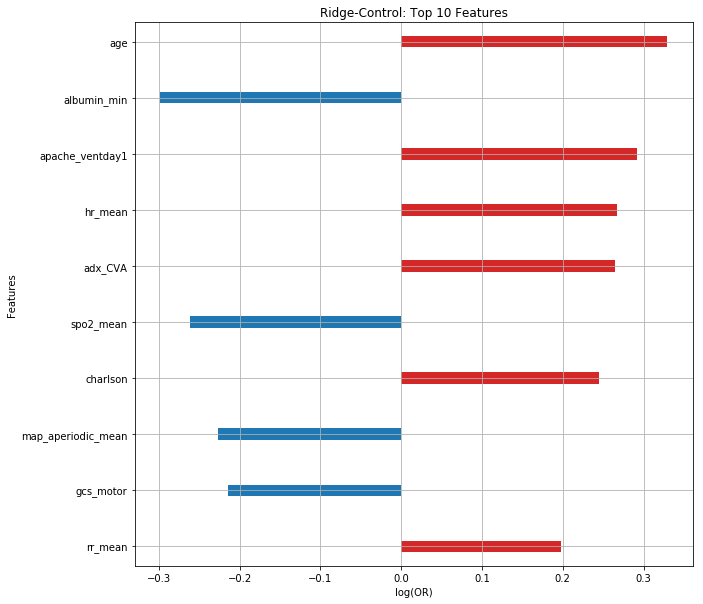

In [5]:
gen_logodds_plot(ridge_classifier, feature_names, n_features=10, 
                 title='Ridge-Control: Top 10 Features', save_name='ridge_Control-feat')

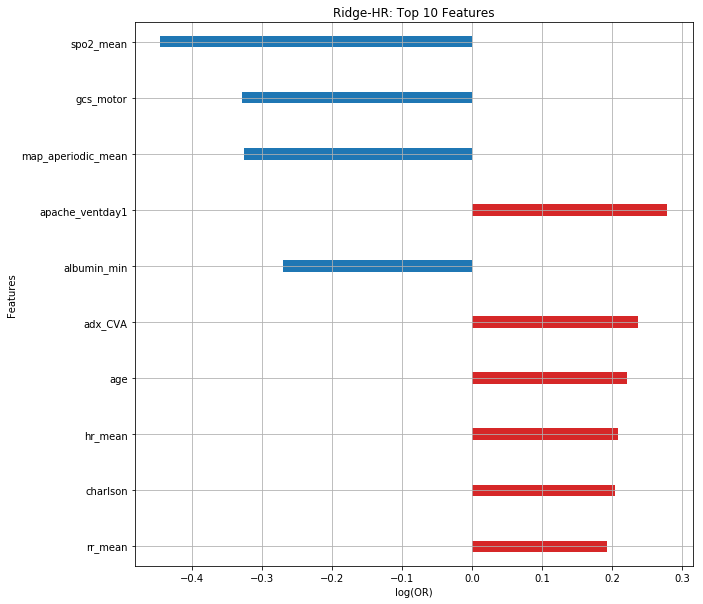

In [6]:
gen_logodds_plot(ridge_classifier_HR, feature_names, n_features=10, 
                 title='Ridge-HR: Top 10 Features', save_name='ridge_HR-feat')

The top 10 features in both regression models by $|log(OR)|$ are identical for both the control and HR cohort models with differences in the weighting.

## 3 - Feature Analysis: Gradient Boosting Machine Models

`xgBoost` comes with a built in feature importance plotting function, and so we need only extract the appropriate information from our model. We begin by creating a feature name mapper for use with this function.

In [7]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}

We then determine the importance matrix via information gain for the control group model, mapping the feature names appropriately.

In [8]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier.get_booster().get_score(importance_type='gain').items()}

Finally, we generate an importance plot using the built in `plot_importance` function.

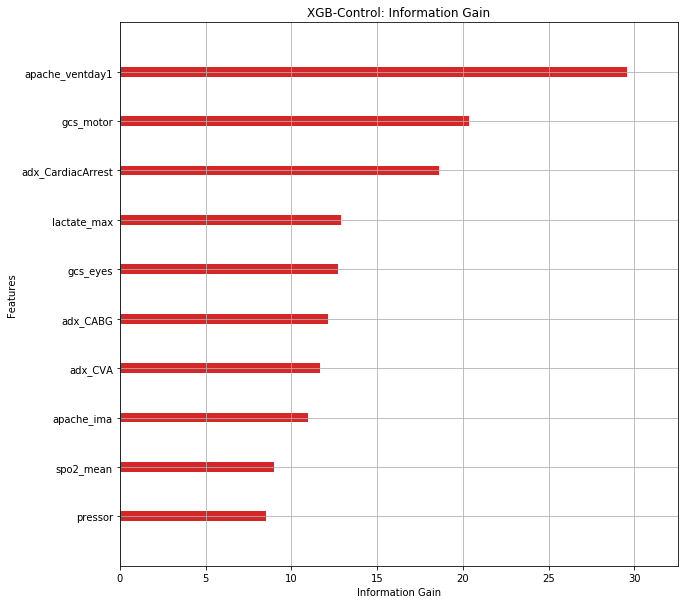

In [9]:
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=10, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
               title='XGB-Control: Information Gain')
plt.savefig('./figures/XGB_Control-feat.svg', bbox_inches='tight')
plt.show()

Similarly, we extract the importance by information gain from the high-risk model.

In [10]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier_HR.get_booster().get_score(importance_type='gain').items()}

And then again we use the `plot_importance` function.

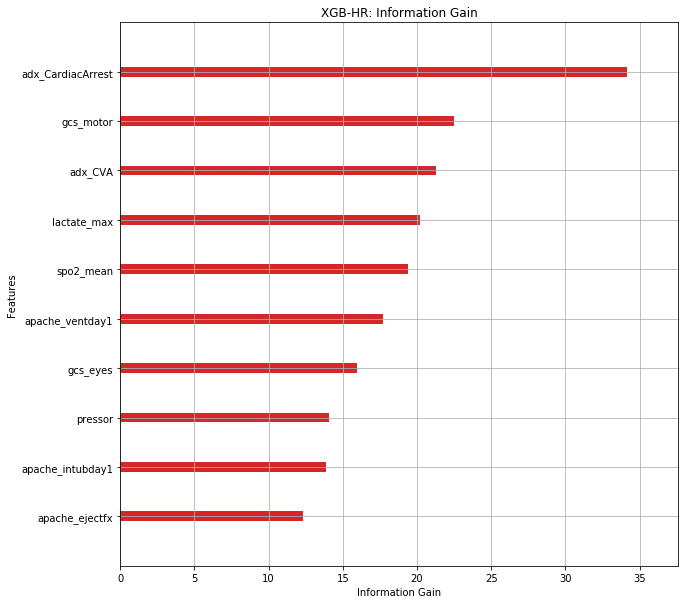

In [11]:
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=10, color=tableau20[6], importance_type='gain', 
                xlabel='Information Gain', ax=plt.axes(), show_values=False,
                title='XGB-HR: Information Gain')
plt.savefig('./figures/XGB_HR-feat.svg', bbox_inches='tight')
plt.show()

Again we note large overlaps in what features were _important_, although this time the top 10 features are not identifcal.